# Predicting Heart Disease: DSCI 100 Group Project Report  (Group 23)

### Introduction:

Cardiovascular diseases (CVDs), or heart diseases, encompasses a range of medical conditions that affect the heart and blood vessels. Worldwide, CVDs are the leading cause of death with nearly 18 million deaths a year (World Health Organization, 2023). Early detection is key to treatment, prevention, and management of heart disease; our data analysis aims to help with this. 

The dataset used is from: https://archive.ics.uci.edu/dataset/45/heart+disease. The data was published in 1988 and the dataset we are using is the one specifically collected in Cleveland. The dataset consists of 303 observations and 14 variables.

The question we aim to address is: **can we predict if a patient has heart disease based on their age, resting blood pressure, serum cholesterol, and maximum resting heart rate?**

In [1]:
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
library(repr)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#These lines of code bring the data into R and make it into a table showing the first 15 rows
download.file("https://raw.githubusercontent.com/Aamitoz-Sharma/Group_23_project/main/heart.csv", "heart_data.csv") #downloading file
heart_data <- read_csv("heart_data.csv")
head(heart_data)


Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [3]:
#This set of data will select the data points we are interested in Age, Resting blood pressure, Cholesterol, Max heart rate and Heart Disease
heart <- heart_data |> 
    select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease) |>
#This line changes the Heart Disease variable from a continous quantitative variable(dbl) to a categorical variable(fct)
    mutate(HeartDisease = as_factor(HeartDisease)) |>
#This line changes the factor variables from 0 to no and 1 to yes
    mutate(HeartDisease = fct_recode(HeartDisease, "yes" = "1", "no" = "0")) 
head(heart)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
49,160,180,156,yes
37,130,283,98,no
48,138,214,108,yes
54,150,195,122,no
39,120,339,170,no


In [4]:

#splitting into training and testing data as this allows us to know how good our model is and if it is making any mistakes
heart_split <- initial_split(heart, prop = 0.75, strata = HeartDisease) #splitting into training and testing data.
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

head(heart_train)
head(heart_test)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
54,150,195,122,no
39,120,339,170,no
54,110,208,142,no
48,120,284,120,no
37,130,211,142,no
39,120,204,145,no


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
37,130,283,98,no
45,130,237,170,no
43,120,201,165,no
60,100,248,125,yes
52,120,284,118,no


In [5]:
# Finding the k for age vs Resting Blood pressure
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

heart_recipe <- recipe(HeartDisease ~Age+RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_vs_BP_best_k <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_vs_BP_best_k

[1] 51

In [ ]:
# Finding the k for age vs cholesterol
heart_recipe_2 <- recipe(HeartDisease ~Age+Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_vs_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_2) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_vs_Cholesterol_best_k

In [ ]:
# Finding the k for age vs MaxHR
heart_recipe_3 <- recipe(HeartDisease ~Age+MaxHR,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_vs_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_3) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_vs_MaxHR_best_k 

In [ ]:
# Finding the k for cholestrol vs MaxHR
heart_recipe_4 <- recipe(HeartDisease ~ MaxHR+Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Cholesterol_vs_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_4) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Cholesterol_vs_MaxHR_best_k 

In [ ]:
# Finding the k for BP vs MaxHR
heart_recipe_5 <- recipe(HeartDisease ~ MaxHR+RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

BP_vs_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_5) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
BP_vs_MaxHR_best_k 

In [ ]:
# Finding the k for BP vs Cholesterol
heart_recipe_6 <- recipe(HeartDisease ~ Cholesterol+RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

BP_vs_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_6) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
BP_vs_Cholesterol_best_k 

In [ ]:
heart_recipe_0.1 <- recipe(RestingBP ~ Age,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_vs_BP_best_k ) |>
  set_engine("kknn") |>
  set_mode("regression")

heart_fit <- workflow() |>
        add_recipe(heart_recipe_0.1) |>
        add_model(heart_spec) |>
        fit(data = heart_train)

Heart_preds <- heart_fit |>
        predict(heart_train) |>
        bind_cols(heart_train) 

heart_plot_1 <- Heart_preds|>
        mutate(full_predictions = .pred)|>
        ggplot(aes(x=Age,y=RestingBP))+
        geom_point(alpha=0.4)+
        geom_line( mapping=aes(x = Age,y = .pred), color="blue")+
        labs(x="Age(years)", y = "Resting Blood Pressure(mm Hg)")+
        ggtitle("Age vs resting Blood Pressure")+
facet_grid(rows = vars(HeartDisease))
heart_plot_1

In [ ]:
heart_recipe_2.1 <- recipe(RestingBP ~ Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_vs_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("regression")

heart_fit <- workflow() |>
        add_recipe(heart_recipe_2.1) |>
        add_model(heart_spec) |>
        fit(data = heart_train)

heart_plot_2 <- Heart_preds|>
        mutate(full_predictions = .pred)|>
        ggplot(aes(x=Age,y=Cholesterol))+
        geom_point(alpha=0.4)+
        geom_line( mapping=aes(x = Age,y = .pred), color="blue")+
        labs(x="Age(years)", y = "Cholestrol(mm/dl)")+
        ggtitle("Age vs Cholesterol")+
facet_grid(rows = vars(HeartDisease))
heart_plot_2

In [ ]:
heart_recipe_3.1 <- recipe(RestingBP ~ Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_vs_MaxHR_best_k) |>
  set_engine("kknn") |>
  set_mode("regression")

heart_fit <- workflow() |>
        add_recipe(heart_recipe_3.1) |>
        add_model(heart_spec) |>
        fit(data = heart_train)

heart_plot_3 <- Heart_preds|>
        mutate(full_predictions = .pred)|>
        ggplot(aes(x=Age,y=MaxHR))+
        geom_point(alpha=0.4)+
        geom_line( mapping=aes(x = Age,y = .pred), color="blue")+
        labs(x="Age(years)", y = "Max heart rate (bpm)")+
        ggtitle("Age vs Max heart rate")+
facet_grid(rows = vars(HeartDisease))
heart_plot_3

In [ ]:
heart_recipe_6.1 <- recipe(RestingBP ~ Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = BP_vs_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("regression")

heart_fit <- workflow() |>
        add_recipe(heart_recipe_6.1) |>
        add_model(heart_spec) |>
        fit(data = heart_train)
heart_plot_6 <- Heart_preds|>
        mutate(full_predictions = .pred)|>
        ggplot(aes(x=Cholesterol,y=RestingBP))+
        geom_point(alpha=0.4)+
        geom_line( mapping=aes(x = Cholesterol,y = .pred), color="blue")+
        labs(x="Cholestrol(mm/dl)", y = "Resting Blood Pressure(mm Hg)")+
        ggtitle("Cholesterol vs resting Blood Pressure")+
facet_grid(rows = vars(HeartDisease))
heart_plot_6

Warning message:
“tune samples were requested but there were 688 rows in the data. 683 will be used.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6526111,5,0.011149104,Preprocessor1_Model01
3,accuracy,binary,0.6817028,5,0.014905998,Preprocessor1_Model02
4,accuracy,binary,0.6817028,5,0.014905998,Preprocessor1_Model03
5,accuracy,binary,0.6992001,5,0.015000498,Preprocessor1_Model04
6,accuracy,binary,0.6992001,5,0.015000498,Preprocessor1_Model05
7,accuracy,binary,0.7035585,5,0.009565355,Preprocessor1_Model06
8,accuracy,binary,0.7035585,5,0.009565355,Preprocessor1_Model07
9,accuracy,binary,0.7136828,5,0.013426004,Preprocessor1_Model08
10,accuracy,binary,0.7136828,5,0.013426004,Preprocessor1_Model09


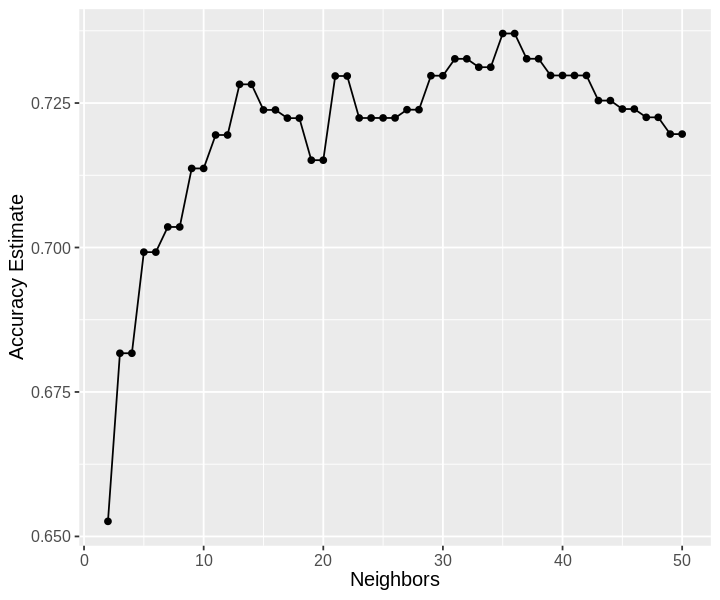

In [15]:
# classification for all predictors: picking the best 


# Set the seed. Don't remove this!
set.seed(1234) 

options(repr.plot.height = 5, repr.plot.width = 6)

# your code here

heart_recipe <- recipe(HeartDisease ~., data = heart_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

vfold <- vfold_cv(heart_train, v = 5, strata = HeartDisease)

k_vals <- tibble(neighbors = seq(from = 2, to = 50, by = 1))

results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_train) |>
    tune_grid(resamples = vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- results |>
  filter(.metric == "accuracy")
accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

cross_val_plot

In [16]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 35

In [21]:
# building the model
# Set the seed. Don't remove this!
set.seed(1234) 

    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 35) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(knn_spec) |>
       fit(data = heart_train)

heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(35,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2674419
Best kernel: rectangular
Best k: 35

In [22]:
heart_test_predictions <- predict(heart_fit, heart_test) |>
       bind_cols(heart_test)
heart_test_predictions

.pred_class,Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
no,40,140,289,172,no
yes,37,130,283,98,no
no,45,130,237,170,no
no,43,120,201,165,no
no,60,100,248,125,yes
yes,52,120,284,118,no
yes,53,113,468,127,no
yes,53,145,518,130,yes
no,41,130,172,130,yes


In [23]:
heart_prediction_accuracy <- heart_test_predictions |>
         metrics(truth = HeartDisease, estimate = .pred_class)    
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6608696
kap,binary,0.3155284
